In [80]:
import pandas as pd
import librosa
import os
import numpy as np
import re
from pydub import AudioSegment
import noisereduce as nr


In [81]:
df = pd.read_csv('./data/results_wav.csv', sep=';')

df.head()

,title,nama_lagu,region,keyword,duration,url,path,wav_path
0,Bungong Jeumpa - Putri Ariani Cover (Lagu Daer...,Bungong Jeumpa,Aceh,Bungong Jeumpa asal Aceh,2.40,https://www.youtube.com/watch?v=RjI7W_XmzLM&pp...,datasets/songs/bungong_jeumpa_putri_ariani_cov...,datasets/wav_songs/bungong_jeumpa_putri_ariani...
1,Bungong Jeumpa | Lirik dan Terjemahan | Lagu D...,Bungong Jeumpa,Aceh,Bungong Jeumpa asal Aceh,4.03,https://www.youtube.com/watch?v=lAVi2OE2bRY&pp...,datasets/songs/bungong_jeumpa_lirik_dan_terjem...,datasets/wav_songs/bungong_jeumpa_lirik_dan_te...
2,Tari Bungong Jeumpa Aceh |Rumah Belajar Mawinsya,Bungong Jeumpa,Aceh,Bungong Jeumpa asal Aceh,3.30,https://www.youtube.com/watch?v=W3PRdCxocM0&pp...,datasets/songs/tari_bungong_jeumpa_aceh_rumah_...,datasets/wav_songs/tari_bungong_jeumpa_aceh_ru...
3,KAKA ALFARISI - BUNGONG JEUMPA (OFFICIAL VIDEO),Bungong Jeumpa,Aceh,Bungong Jeumpa asal Aceh,4.21,https://www.youtube.com/watch?v=N9JDR0ZH4AU&pp...,datasets/songs/kaka_alfarisi_bungong_jeumpa_of...,datasets/wav_songs/kaka_alfarisi_bungong_jeump...
4,"TARI ""BUNGONG JEUMPA"" BERASAL DARI ACEH",Bungong Jeumpa,Aceh,Bungong Jeumpa asal Aceh,3.35,https://www.youtube.com/watch?v=3iToqU4LnPU&pp...,datasets/songs/tari_bungong_jeumpa_berasal_dar...,datasets/wav_songs/tari_bungong_jeumpa_berasal...


In [82]:
def get_duration(file_path):
    if pd.isna(file_path):  # Menangani NaN atau None
        print('Skipping: file path is NaN or None')
        return None, None
    
    y, sr = librosa.load(file_path)
    duration = librosa.get_duration(y=y, sr=sr)
    print(f'sample rate: {sr}, duration: {duration}')
    return sr, duration

In [83]:
df['sample_rate'], df['duration_sec'] = zip(*df['wav_path'].map(get_duration))


sample rate: 22050, duration: 159.79972789115646
sample rate: 22050, duration: 242.13768707482993
sample rate: 22050, duration: 209.62975056689342
sample rate: 22050, duration: 260.92263038548754
sample rate: 22050, duration: 214.7613605442177
sample rate: 22050, duration: 253.60834467120182
sample rate: 22050, duration: 257.5092970521542
sample rate: 22050, duration: 258.02013605442176
sample rate: 22050, duration: 148.21297052154196
sample rate: 22050, duration: 254.44426303854874
sample rate: 22050, duration: 248.59283446712018
sample rate: 22050, duration: 179.67600907029478
sample rate: 22050, duration: 153.83219954648527
sample rate: 22050, duration: 151.3012244897959
sample rate: 22050, duration: 173.17442176870748
sample rate: 22050, duration: 259.088253968254
sample rate: 22050, duration: 150.14022675736962
sample rate: 22050, duration: 284.97850340136057
sample rate: 22050, duration: 284.1425850340136
sample rate: 22050, duration: 273.786485260771
sample rate: 22050, duration

In [84]:
df.describe()

,duration,sample_rate,duration_sec
count,105.000000,105.0,105.000000
mean,3.376476,22050.0,214.418369
std,1.019927,0.0,61.811043
min,0.100000,22050.0,9.404082
25%,2.520000,22050.0,171.665125
50%,3.360000,22050.0,215.365079
75%,4.240000,22050.0,263.685805
max,5.000000,22050.0,299.049796


In [86]:
def sanitize_filename(filename):
    """
    Removes or replaces invalid characters from a filename or folder name.
    """
    return re.sub(r'[<>:"/\\|?*]', '', filename)

def normalized_yt_title(title):
    text = title.lower()
    text = text.replace(' ', '_')
    text = re.sub(r'[^a-z0-9_]', '', text)
    text = re.sub(r'_{2,}', '_', text)
    
    return text

split_result = []

def split_songs_to_segments(df, output_base_folder='datasets/30s_segments'):
    for index, row in df.iterrows():
        wav_path = row['wav_path']
        title = row['title']
        region = row['region']
        keyword = row['keyword']
        nama_lagu = row['nama_lagu']
        
        # Cek jika wav_path adalah string dan file yang valid
        if isinstance(wav_path, str) and os.path.isfile(wav_path):
            norm_title = normalized_yt_title(nama_lagu)
            norm_region = region.lower().replace(' ', '_')
            output_dir = os.path.join(output_base_folder, norm_region, norm_title + "_" + str(index))
            
            audio = AudioSegment.from_wav(wav_path)
            total_duration = len(audio) / 1000  # Durasi dalam detik
            segment_duration = 30
            num_segments = int(total_duration // segment_duration)


            os.makedirs(output_dir, exist_ok=True)

            for i in range(num_segments):
                start_time = i * segment_duration * 1000
                end_time = (i + 1) * segment_duration * 1000
                segment = audio[start_time:end_time]
                
                segment_file = os.path.join(output_dir, f"segment{i + 1}.wav")
                segment.export(segment_file, format="wav")
                
                split_result.append({
                    'title': nama_lagu,
                    'region': region,
                    'keyword': keyword,
                    '30s_path': segment_file
                })
            print(f"Saved {num_segments} segments in {norm_region} for {title} at: {output_dir}")
        else:
            print(f"Invalid wav_path at index {index}: {wav_path}")


In [87]:
split_songs_to_segments(df)

Saved 5 segments in aceh for Bungong Jeumpa - Putri Ariani Cover (Lagu Daerah Aceh) at: datasets/30s_segments/aceh/bungong_jeumpa_0
Saved 8 segments in aceh for Bungong Jeumpa | Lirik dan Terjemahan | Lagu Daerah Aceh | Dongeng Kita at: datasets/30s_segments/aceh/bungong_jeumpa_1
Saved 6 segments in aceh for Tari Bungong Jeumpa Aceh |Rumah Belajar Mawinsya at: datasets/30s_segments/aceh/bungong_jeumpa_2
Saved 8 segments in aceh for KAKA ALFARISI - BUNGONG JEUMPA (OFFICIAL VIDEO) at: datasets/30s_segments/aceh/bungong_jeumpa_3
Saved 7 segments in aceh for TARI "BUNGONG JEUMPA" BERASAL DARI ACEH at: datasets/30s_segments/aceh/bungong_jeumpa_4
Saved 8 segments in aceh for Jambo - Safira Amalia (Official Music Video) at: datasets/30s_segments/aceh/jambo_jambo_5
Saved 8 segments in aceh for TARIAN ACEH JAMBO JAMBO at: datasets/30s_segments/aceh/jambo_jambo_6
Saved 8 segments in aceh for Jambo at: datasets/30s_segments/aceh/jambo_jambo_7
Saved 4 segments in aceh for Lembah Alas - Lagu Daerah

In [118]:
df_res = pd.DataFrame(split_result)
df_res.head()

,title,region,keyword,30s_path
0,Bungong Jeumpa,Aceh,Bungong Jeumpa asal Aceh,datasets/30s_segments/aceh/bungong_jeumpa_0/se...
1,Bungong Jeumpa,Aceh,Bungong Jeumpa asal Aceh,datasets/30s_segments/aceh/bungong_jeumpa_0/se...
2,Bungong Jeumpa,Aceh,Bungong Jeumpa asal Aceh,datasets/30s_segments/aceh/bungong_jeumpa_0/se...
3,Bungong Jeumpa,Aceh,Bungong Jeumpa asal Aceh,datasets/30s_segments/aceh/bungong_jeumpa_0/se...
4,Bungong Jeumpa,Aceh,Bungong Jeumpa asal Aceh,datasets/30s_segments/aceh/bungong_jeumpa_0/se...


### Feature Extraction

In [130]:
def extract_mfcc_features(wav_path, n_mfcc=13):
    y, sr = librosa.load(wav_path)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfccs_mean = np.mean(mfccs.T, axis=0)
    return mfccs_mean

def extract_spectogram_features(wav_path):
    y, sr = librosa.load(wav_path)
    S = np.abs(librosa.stft(y))
    S_mean = np.mean(S.T, axis=0)
    return S_mean

def extract_features(wav_path):
    mfcc = extract_mfcc_features(wav_path)
    spectogram = extract_spectogram_features(wav_path)
    combined_features = np.concatenate((mfcc, spectogram))
    return combined_features

In [ ]:
# df_res['mfcc_features'] = df_res['30s_path'].apply(extract_mfcc_features)
# df_res['spectogram_features'] = df_res['30s_path'].apply(extract_spectogram_features)
# df_res.head()

,title,region,keyword,30s_path,mfcc_features,spectogram_features
0,Bungong Jeumpa,Aceh,Bungong Jeumpa asal Aceh,datasets/30s_segments/aceh/bungong_jeumpa_0/se...,"[-276.26437, 108.37744, 3.2055633, 19.108044, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,Bungong Jeumpa,Aceh,Bungong Jeumpa asal Aceh,datasets/30s_segments/aceh/bungong_jeumpa_0/se...,"[-92.659065, 116.32815, -0.7250683, 25.506205,...","[[6.3045387, 2.8831224, 0.43407267, 0.3924942,..."
2,Bungong Jeumpa,Aceh,Bungong Jeumpa asal Aceh,datasets/30s_segments/aceh/bungong_jeumpa_0/se...,"[-94.92029, 130.16647, -0.53589445, 27.181755,...","[[7.1608386, 1.1936214, 3.6552777, 2.772754, 0..."
3,Bungong Jeumpa,Aceh,Bungong Jeumpa asal Aceh,datasets/30s_segments/aceh/bungong_jeumpa_0/se...,"[-85.15819, 121.715965, -7.17036, 25.320257, -...","[[7.4575195, 3.2131102, 2.020058, 1.421396, 0...."
4,Bungong Jeumpa,Aceh,Bungong Jeumpa asal Aceh,datasets/30s_segments/aceh/bungong_jeumpa_0/se...,"[-76.72244, 142.57019, -0.97597164, 26.675537,...","[[1.4438195, 9.760082, 0.92664295, 15.659207, ..."


In [91]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

def print_score(clf, X_train, y_train, X_test, y_test, train=True):    
    if train:
        pred = clf.predict(X_train)
        clf_report = classification_report(y_train, pred)
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print(f"F1 Score: {f1_score(y_train, pred, average='weighted') * 100:.2f}%")
        print(f"Precision Score: {precision_score(y_train, pred, average='weighted') * 100:.2f}%")
        print(f"Recall Score: {recall_score(y_train, pred, average='weighted') * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")
        
    elif train==False:
        pred = clf.predict(X_test)
        clf_report = classification_report(y_test, pred)
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print(f"F1 Score: {f1_score(y_test, pred, average='weighted') * 100:.2f}%")
        print(f"Precision Score: {precision_score(y_test, pred, average='weighted') * 100:.2f}%")
        print(f"Recall Score: {recall_score(y_test, pred, average='weighted') * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

### RANDOM FOREST

In [131]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Prepare the data
X = []
y = []

for index, row in df_res.iterrows():
    wav_path = row['30s_path']
    label = row['title']
    
    features = extract_features(wav_path)
    X.append(features)
    y.append(label)
    
X = np.array(X)
y = np.array(y)

In [132]:
print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (695, 1038), y shape: (695,)


In [133]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

### Train Result

In [134]:
# Evaluate the model
print_score(model, X_train, y_train, X_test, y_test, train=True)

Train Result:
Accuracy Score: 99.28%
F1 Score: 99.27%
Precision Score: 99.29%
Recall Score: 99.28%
_______________________________________________
CLASSIFICATION REPORT:
                           precision    recall  f1-score   support

          Aceh Lon Sayang       1.00      1.00      1.00        11
 Alam Wisata Pulau Bangka       1.00      1.00      1.00        26
              Aneuk Yatim       1.00      1.00      1.00         7
           Bungong Jeumpa       1.00      1.00      1.00        28
            Dayung Sampan       1.00      1.00      1.00        28
                 Dewa Ayu       1.00      1.00      1.00         3
                      Ibo       1.00      1.00      1.00         7
        Icak-Icak Dek Tau       1.00      1.00      1.00        31
            Jambo – Jambo       1.00      1.00      1.00        17
            Jereh Bu Guru       1.00      1.00      1.00        23
               Jibeak Weo       1.00      1.00      1.00        31
Lagu Men Sahang Lah Mirah

### Test Result

In [135]:
print_score(model, X_train, y_train, X_test, y_test, train=False)

Test Result:
Accuracy Score: 88.49%
F1 Score: 88.49%
Precision Score: 91.63%
Recall Score: 88.49%
_______________________________________________
CLASSIFICATION REPORT:
                           precision    recall  f1-score   support

          Aceh Lon Sayang       1.00      0.75      0.86         4
 Alam Wisata Pulau Bangka       0.90      0.90      0.90        10
              Aneuk Yatim       0.00      0.00      0.00         1
           Bungong Jeumpa       0.75      1.00      0.86         6
            Dayung Sampan       0.43      1.00      0.60         3
                 Dewa Ayu       1.00      1.00      1.00         2
                      Ibo       1.00      1.00      1.00         1
        Icak-Icak Dek Tau       1.00      1.00      1.00         3
            Jambo – Jambo       1.00      1.00      1.00         7
            Jereh Bu Guru       1.00      0.50      0.67         6
               Jibeak Weo       0.89      1.00      0.94         8
Lagu Men Sahang Lah Mirah 

/home/reiaslite/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/reiaslite/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/reiaslite/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/reiaslite/.loca

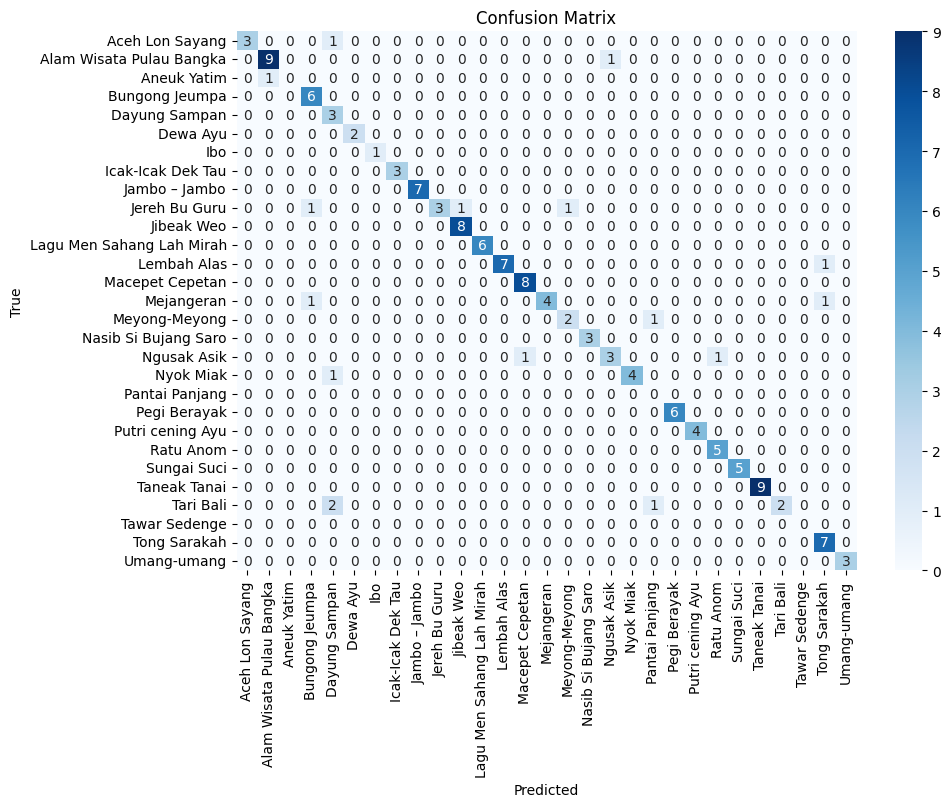

In [136]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

import matplotlib.pyplot as plt

y_pred = model.predict(X_test)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### SVM - Supervised ML

In [137]:
from sklearn.svm import SVC

# Train an SVM model
svm_model = SVC(kernel='linear', random_state=42, C=7.5)
svm_model.fit(X_train, y_train)


SVC(C=7.5, kernel='linear', random_state=42)

In [138]:
# Evaluate the SVM model
print_score(svm_model, X_train, y_train, X_test, y_test, train=True)

Train Result:
Accuracy Score: 99.28%
F1 Score: 99.24%
Precision Score: 99.37%
Recall Score: 99.28%
_______________________________________________
CLASSIFICATION REPORT:
                           precision    recall  f1-score   support

          Aceh Lon Sayang       1.00      1.00      1.00        11
 Alam Wisata Pulau Bangka       1.00      1.00      1.00        26
              Aneuk Yatim       1.00      1.00      1.00         7
           Bungong Jeumpa       1.00      1.00      1.00        28
            Dayung Sampan       1.00      1.00      1.00        28
                 Dewa Ayu       1.00      1.00      1.00         3
                      Ibo       1.00      1.00      1.00         7
        Icak-Icak Dek Tau       1.00      1.00      1.00        31
            Jambo – Jambo       1.00      1.00      1.00        17
            Jereh Bu Guru       1.00      1.00      1.00        23
               Jibeak Weo       1.00      1.00      1.00        31
Lagu Men Sahang Lah Mirah

In [139]:

print_score(svm_model, X_train, y_train, X_test, y_test, train=False)

Test Result:
Accuracy Score: 94.24%
F1 Score: 94.16%
Precision Score: 95.42%
Recall Score: 94.24%
_______________________________________________
CLASSIFICATION REPORT:
                           precision    recall  f1-score   support

          Aceh Lon Sayang       0.80      1.00      0.89         4
 Alam Wisata Pulau Bangka       0.91      1.00      0.95        10
              Aneuk Yatim       1.00      1.00      1.00         1
           Bungong Jeumpa       0.86      1.00      0.92         6
            Dayung Sampan       1.00      1.00      1.00         3
                 Dewa Ayu       1.00      1.00      1.00         2
                      Ibo       1.00      1.00      1.00         1
        Icak-Icak Dek Tau       1.00      1.00      1.00         3
            Jambo – Jambo       1.00      1.00      1.00         7
            Jereh Bu Guru       0.71      0.83      0.77         6
               Jibeak Weo       1.00      1.00      1.00         8
Lagu Men Sahang Lah Mirah 

### Decision Tree's

In [140]:
from sklearn.tree import DecisionTreeClassifier

# Train a Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [ ]:
# Evaluate the Decision Tree model on the training data
print_score(dt_model, X_train, y_train, X_test, y_test, train=True)

Train Result:
Accuracy Score: 99.28%
F1 Score: 99.24%
Precision Score: 99.37%
Recall Score: 99.28%
_______________________________________________
CLASSIFICATION REPORT:
                           precision    recall  f1-score   support

          Aceh Lon Sayang       1.00      1.00      1.00        11
 Alam Wisata Pulau Bangka       1.00      1.00      1.00        26
              Aneuk Yatim       1.00      1.00      1.00         7
           Bungong Jeumpa       1.00      1.00      1.00        28
            Dayung Sampan       1.00      1.00      1.00        28
                 Dewa Ayu       1.00      1.00      1.00         3
                      Ibo       1.00      1.00      1.00         7
        Icak-Icak Dek Tau       1.00      1.00      1.00        31
            Jambo – Jambo       1.00      1.00      1.00        17
            Jereh Bu Guru       1.00      1.00      1.00        23
               Jibeak Weo       1.00      1.00      1.00        31
Lagu Men Sahang Lah Mirah

In [142]:
# Evaluate the Decision Tree model on the test data
print_score(dt_model, X_train, y_train, X_test, y_test, train=False)

Test Result:
Accuracy Score: 67.63%
F1 Score: 67.56%
Precision Score: 70.81%
Recall Score: 67.63%
_______________________________________________
CLASSIFICATION REPORT:
                           precision    recall  f1-score   support

          Aceh Lon Sayang       0.00      0.00      0.00         4
 Alam Wisata Pulau Bangka       0.69      0.90      0.78        10
              Aneuk Yatim       0.00      0.00      0.00         1
           Bungong Jeumpa       0.50      0.67      0.57         6
            Dayung Sampan       1.00      0.67      0.80         3
                 Dewa Ayu       1.00      1.00      1.00         2
                      Ibo       0.50      1.00      0.67         1
        Icak-Icak Dek Tau       1.00      0.67      0.80         3
            Jambo – Jambo       0.83      0.71      0.77         7
            Jereh Bu Guru       0.33      0.17      0.22         6
               Jibeak Weo       0.62      1.00      0.76         8
Lagu Men Sahang Lah Mirah 

/home/reiaslite/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/reiaslite/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/reiaslite/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/reiaslite/.loca